In [1]:
import os, sys
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import dill
import utm
import math
from stl import mesh # install with `pip install numpy-stl`
from scipy.interpolate import RectBivariateSpline, griddata

In [2]:
from mmctools.coupling.terrain import readSTL
from mmctools.coupling.terrain import SRTM
from openfast_toolbox.fastfarm.AMRWindSimulation import AMRWindSimulation
from openfast_toolbox.fastfarm.FASTFarmCaseCreation import FFCaseCreation, modifyProperty

# TotalEnergies: Complex Terrain Workflow Demonstration
## Get terrain and turbine information and create AMR-Wind input files with domain, refinements, turbines, and FF boxes
## Biglow Canyon III (Siemens wind turbines)

Regis Thedin

# 0. Output paths

In [3]:
basepath = os.path.join('/scratch/rthedin/forMaxime')

In [4]:
# Basepath output for AMR-Wind-related input files (will be appended the `case` name, created two cells down)
amrdir_basepath = os.path.join(basepath,'amrwind_inputs')

if not os.path.exists(amrdir_basepath): os.mkdir(amrdir_basepath)

In [5]:
# Output directory for STL
outdir = os.path.join(basepath,'stl')
if not os.path.exists(outdir): os.mkdir(outdir)

# 1. Get terrain info

## 1.1 Terrain parameters


First, set the resolution of the data the STL will be created from, and the output resolution.

In [6]:
product = 'SRTM1' # SRTM1 | SRTM3 (30- and 90-m DEM)
ds = 30. # output resolution

The following cell should be modified by the user, following the examples given. The cell contains information about the actual location to be saved.

The `refloc` variable is the location coresponding to (0,0) in SOWFA.

Set the fringe on each side of the domain. This fringe region will used to blend the high-resolution SRTM domain data with either i) low-reosolution WRF (mesoscale) digital elevation model (DEM), or ii) flat.

If `getWRFdata` above is `True`, then blending to mesoscale will occur; otherwise, the domain will be blended to flat. If blending to flat, the user can specify an extra fringe region of completely flat domain (`fringe_flat`). Additionally, if blending to flat, the terrain surface data can be shifted vertically such that the flat region is at $z=0$ by setting `shiftFlatToZero` to `True`.

With respect to the bounding box, it is nice to have the boundaries exactly where the mesh would go because of the blending. For instance, a 5x5 km domain needs to match all the levels of cells: 20, 40, 80, 160 m. Essentially, 5000/160 needs to be an integer number, the same way 5000/80 needs to be as well. However, we only really need to match the coarsest resolution because they are multiple. Finally, an extra fringe of width `ds` (the resolution set above) is added, half on each side. The desired bounding box should go into the `xmin`,`xmax`,`ymin`,`ymax` variables, ignoring the `ds` addition. This extra fringe is to ensure that the STL is slighly larger than the bounding box that will be set on the microscale solver (needed in OpenFOAM to avoid numerical issues).

#### WFIP2/Biglow region

In [7]:
# For WFIP2 region. Large region for boundary coupling study, Fits both 20/40/80/160 and 30/60/120/240m grids, as well as 756m low-res WRF-like grids
refloc = (45.638004, -120.642973, 495) # biglow PS12 met mast

xmin,xmax = -15000-ds/2, 9960+ds/2
ymin,ymax = -7000-ds/2, 10280+ds/2 #  for a 30x20km terrain area
#ymin,ymax = -15000-ds/2, 13800+ds/2  # for a 30x30km terrain area


# Fringe for flat-blending
fringe_w = 1000
fringe_s = 2000
fringe_n = 2000
fringe_e = 2000

shiftFlatToZero=False  # no shifting here as `zlo` needs to be ==min(z)

fringe_flat=80;   # user modifiable, extra totally-flat fringe at the edges
getWRFdata=False  # do not modify
saveFig=False     # do not modify
caseBlendString = f'2N2S2E1W_ff{fringe_flat}'   # user modifiable
    
case =  f'tte_wfip_biglow2_xm{abs(int(xmin))}to{int(xmax)}_ym{abs(int(ymin))}to{int(ymax)}_ds{ds}'

In [8]:
amrdir = os.path.join(amrdir_basepath, case)
if not os.path.exists(amrdir): os.mkdir(amrdir)

### 1.1.1. Print info

In [9]:
# limits of the LES domain. The limits of the STL file are res/2 larger on each side.
xminLES = xmin+ds/2
xmaxLES = xmax-ds/2
yminLES = ymin+ds/2
ymaxLES = ymax-ds/2

extentx = xmax-xmin-ds
extenty = ymax-ymin-ds

# Prints number of cells for each level. I only want integers here, ideally
print(f'Number of cells in each direction for a given cell size\n')
print(f'cell size| {extentx:.1f} m in x      {extenty:.1f} m in y')
print('--------------------------------------------------')
for i in [30,60,120,240,480,960,  20,40,80,160,320,640]:
    print(i,'\t | ',extentx/i,'\t\t  ', extenty/i)
    if i==960: print('--------------------------------------------------')

Number of cells in each direction for a given cell size

cell size| 24960.0 m in x      17280.0 m in y
--------------------------------------------------
30 	 |  832.0 		   576.0
60 	 |  416.0 		   288.0
120 	 |  208.0 		   144.0
240 	 |  104.0 		   72.0
480 	 |  52.0 		   36.0
960 	 |  26.0 		   18.0
--------------------------------------------------
20 	 |  1248.0 		   864.0
40 	 |  624.0 		   432.0
80 	 |  312.0 		   216.0
160 	 |  156.0 		   108.0
320 	 |  78.0 		   54.0
640 	 |  39.0 		   27.0


## 1.2. Create output surface

In [10]:
x1 = np.arange(xmin, xmax+ds, ds)
y1 = np.arange(ymin, ymax+ds, ds)
xsurf,ysurf = np.meshgrid(x1, y1, indexing='ij')

In [11]:
print('The output bounding box is')
print('xmin: ',xsurf[0,0], '\nxmax: ',xsurf[-1,-1])
print('ymin: ',ysurf[0,0], '\nymax: ',ysurf[-1,-1])

The output bounding box is
xmin:  -15015.0 
xmax:  9975.0
ymin:  -7015.0 
ymax:  10295.0


## 1.3. Get the high-resolution terrain

In [12]:
# Terrain region to clip from the digital elevation model (DEM)
srtm_bounds = west, south, east, north = (refloc[1]-0.5, refloc[0]-0.4, refloc[1]+0.6, refloc[0]+0.4)
srtm_bounds = west, south, east, north = (refloc[1]-0.2, refloc[0]-0.2, refloc[1]+0.2, refloc[0]+0.2)

# this will be downloaded:
srtm_output=f'{outdir}/{case}.tif' # need absolute path for GDAL

In [13]:
srtm = SRTM(srtm_bounds, fpath=srtm_output, product=product)
srtm.download()

make: Entering directory '/home/rthedin/.cache/elevation/SRTM1'
make: Nothing to be done for 'download'.
make: Leaving directory '/home/rthedin/.cache/elevation/SRTM1'
make: Entering directory '/home/rthedin/.cache/elevation/SRTM1'
make: Nothing to be done for 'all'.
make: Leaving directory '/home/rthedin/.cache/elevation/SRTM1'
make: Entering directory '/home/rthedin/.cache/elevation/SRTM1'
cp SRTM1.vrt SRTM1.1902f7921b324c35a29302cd8cb1ccdf.vrt
make: Leaving directory '/home/rthedin/.cache/elevation/SRTM1'
make: Entering directory '/home/rthedin/.cache/elevation/SRTM1'
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin -120.892973 45.888004 -120.392973 45.388004 SRTM1.1902f7921b324c35a29302cd8cb1ccdf.vrt /scratch/rthedin/forMaxime/stl/tte_wfip_biglow2_xm15015to9975_ym7015to10295_ds30.0.tif
rm -f SRTM1.1902f7921b324c35a29302cd8cb1ccdf.vrt
make: Leaving directory '/home/rthedin/.cache/elevation/SRTM1'
make: Entering directory '/home/rthedin/.cach

In [14]:
# original SRTM terrain stored as 'z'
x,y,z = srtm.to_terrain()

Output grid at ds= 30.0
Projecting from EPSG:4326 to EPSG:32610


In [15]:
# get reference location to use as origin
xref,yref,_,_ = utm.from_latlon(*refloc[:2], force_zone_number=srtm.zone_number)

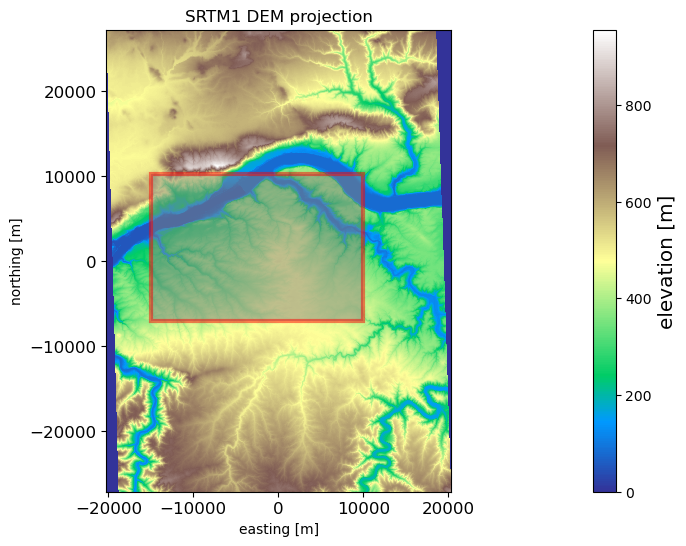

In [16]:
fig,ax = plt.subplots(figsize=(9,6))
cm = ax.pcolormesh(x-xref, y-yref, z, shading='auto', cmap='terrain')#,vmin=1500,vmax=2500)
cb = fig.colorbar(cm,ax=ax)
cb.set_label('elevation [m]',fontsize='x-large')
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]'); ax.set_ylabel('northing [m]')
ax.set_title(f'{product} DEM projection')
ax.axis('scaled')

# bounding box for microscale region
les = Rectangle((xmin,ymin), xmax-xmin, ymax-ymin, edgecolor='r', lw=3, facecolor='0.5', alpha=0.5)
ax.add_patch(les)
plt.show()

### 1.3.1 Downscale to output grid

In [17]:
interpfun = RectBivariateSpline(x[:,0]-xref, y[0,:]-yref, z)

In [18]:
# resampled SRTM data stored in 'zsrtm'
zsrtm = interpfun(x1,y1,grid=True)

## 1.4. Blend fringe definitions

In [19]:
# check distance from west boundary
blend_w = np.ones(xsurf.shape)
if fringe_w > 0:
    blend_w = np.minimum(np.maximum((xsurf-xmin-fringe_flat)/fringe_w, 0), 1)

In [20]:
# check distance from east boundary
blend_e = np.ones(xsurf.shape)
if fringe_e > 0:
    blend_e = np.minimum(np.maximum((xmax-xsurf-fringe_flat)/fringe_e, 0), 1)

In [21]:
# check distance from south boundary
blend_s = np.ones(xsurf.shape)
if fringe_s > 0:
    blend_s = np.minimum(np.maximum((ysurf-ymin-fringe_flat)/fringe_s, 0), 1)

In [22]:
# check distance from north boundary
blend_n = np.ones(xsurf.shape)
if fringe_n > 0:
    blend_n = np.minimum(np.maximum((ymax-ysurf-fringe_flat)/fringe_n, 0), 1)

In [23]:
# combine blending functions
blend = blend_w * blend_e * blend_s * blend_n

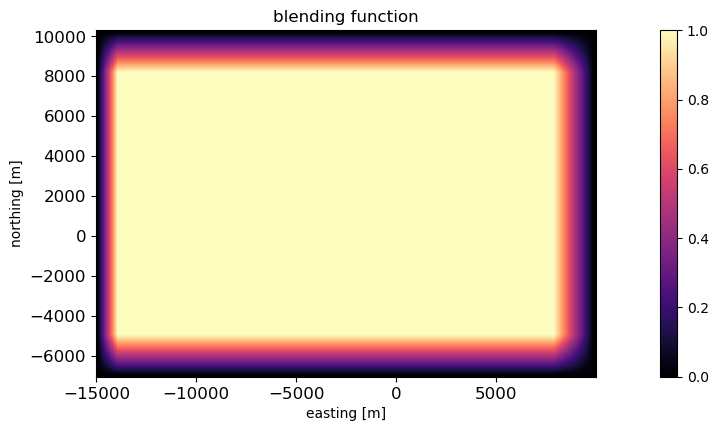

In [24]:
fig,ax = plt.subplots(figsize=(9,4.5))
cm = ax.pcolormesh(xsurf, ysurf, blend, shading='auto', cmap='magma')
cb = fig.colorbar(cm,ax=ax)
ax.tick_params(labelsize='large')
ax.set_xlabel('easting [m]')
ax.set_ylabel('northing [m]')
ax.set_title('blending function')
ax.axis('scaled')
plt.show()

### 1.4.1. Blending and shift lowest point to zero

In [25]:
# Get amount for all surfaces to be shifted
zero = zsrtm.min()

In [26]:
# create flat surface to be blended
zflat = np.full(zsrtm.shape, zero)

In [27]:
# now, blend the high/low resolution elevations
zblendflat = blend*zsrtm + (1-blend)*zflat
zblendflatshift = zblendflat - zero

if getWRFdata is True:
    zblendwrf = blend*zsrtm + (1-blend)*zwrf
    zblendwrfshift = zblendwrf - zero

In [28]:
# shift non-blended terrains, both WRF and SRTM resolution
zsrtmshift = zsrtm - zero

## 1.5. Visualize terrains

In [29]:
saveFig=False

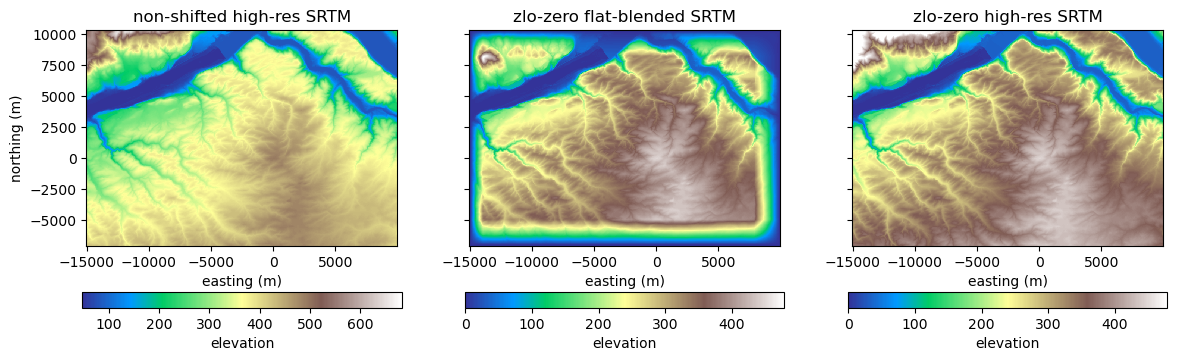

In [30]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), sharey=True)
axs=axs.flatten()

cm = axs[0].pcolormesh(xsurf, ysurf, zsrtm, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=axs[0], orientation='horizontal', label='elevation')
vmin = cb.vmin; vmax = cb.vmax
axs[0].set_title('non-shifted high-res SRTM')

cm = axs[1].pcolormesh(xsurf, ysurf, zblendflatshift, shading='auto', cmap='terrain')
cb = fig.colorbar(cm,ax=axs[1], orientation='horizontal', label='elevation')
vmin = cb.vmin; vmax = cb.vmax
axs[1].set_title('zlo-zero flat-blended SRTM')

cm = axs[2].pcolormesh(xsurf, ysurf, zsrtmshift, shading='auto', cmap='terrain',vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=axs[2], orientation='horizontal', label='elevation')
axs[2].set_title('zlo-zero high-res SRTM')


axs[0].set_ylabel('northing (m)')
for ax in axs:
    ax.set_xlabel('easting (m)')
    ax.axis('scaled')

plt.show()

if saveFig: fig.savefig(f'{outdir}/{case}.png',dpi=150,bbox_inches='tight', transparent=False)

## 1.6. Write out terrain surface STL

In [31]:
def saveSTL (xsurf, ysurf, z, stlout):
    
    # output 'z' surface
    Npts = np.prod(xsurf.shape)
    stlpoints = np.stack((xsurf.ravel(),
                          ysurf.ravel(),
                          z.ravel()),  # <-- output surface here
                         axis=-1)

    stlindices = np.reshape(np.arange(Npts), xsurf.shape)

    Nx,Ny = xsurf.shape
    Nfaces = (Nx-1)*(Ny-1)*2
    surf = mesh.Mesh(np.zeros(Nfaces, dtype=mesh.Mesh.dtype))

    # manually define triangular faces for this simple quad mesh
    iface = 0 
    for i in range(Nx-1):
        for j in range(Ny-1):
            surf.vectors[iface,0,:] = stlpoints[stlindices[i,j],:]
            surf.vectors[iface,1,:] = stlpoints[stlindices[i+1,j],:]
            surf.vectors[iface,2,:] = stlpoints[stlindices[i+1,j+1],:]
            surf.vectors[iface+1,0,:] = stlpoints[stlindices[i+1,j+1],:]
            surf.vectors[iface+1,1,:] = stlpoints[stlindices[i,j+1],:]
            surf.vectors[iface+1,2,:] = stlpoints[stlindices[i,j],:]
            iface += 2
    assert (iface == Nfaces)

    dpath = os.path.dirname(stlout)
    if (not dpath == '') and (not os.path.isdir(dpath)):
        os.makedirs(dpath)
        print('Created',dpath)

    surf.save(stlout)
    # surf.save(stlout, mode=mesh.stl.ASCII) # if ASCII STL is needed
    print('Saved',stlout)

In [32]:
# Saving the STL files.

stlout = os.path.join(outdir, f'{case}_SRTMblendToFlat_{caseBlendString}_zerozlo.stl')
z= zblendflatshift
saveSTL(xsurf, ysurf, z, stlout)

stlout = os.path.join(outdir, f'{case}_SRTMres_zerozlo.stl')
z= zsrtmshift
saveSTL(xsurf, ysurf, z, stlout)

Saved /scratch/rthedin/forMaxime/stl/tte_wfip_biglow2_xm15015to9975_ym7015to10295_ds30.0_SRTMblendToFlat_2N2S2E1W_ff80_zerozlo.stl
Saved /scratch/rthedin/forMaxime/stl/tte_wfip_biglow2_xm15015to9975_ym7015to10295_ds30.0_SRTMres_zerozlo.stl


In [33]:
# Put terrain in xarray for format for easier slicing
dsstl = xr.Dataset(
           data_vars=dict(
                      zstl_flatblend = (["x", "y"], zblendflatshift),
                      zstl_noblend   = (["x", "y"], zsrtmshift),   ),
           coords=dict(
                   x=("x", x1),
                   y=("y", y1), )
)

## 1.7. Generate points for terrain-following slices

In [34]:
# Original desired terrain resolution that the STL was saved in: `ds`
# For convenience, pick a sampling resolution that is a multiple of the STL resolution
# Other resolutions can be done with small adaptations
samp_res = int(3*30)

ratio_res = int(samp_res/30)
terrfollowing = dsstl.isel(x=slice(None,None, ratio_res), y=slice(None,None,ratio_res))['zstl_flatblend']

In [35]:
heightAGL = [80, 160]

In [36]:
amrinfo_sampling_terr = os.path.join(amrdir, 'sampling_terrainfollowing.i')

fid = open(amrinfo_sampling_terr, 'w')

fid.write(f'incflo.post_processing               = terr\n\n')

labels = ''.join([f'terrain{h}m ' for h in heightAGL])
fid.write(f'terr.output_format                   = netcdf\n')
fid.write(f'terr.output_frequency                = 200    # 10 s at dt=0.05\n')
fid.write(f'terr.fields                          = velocity\n')
fid.write(f'terr.labels                          = {labels}\n\n')

for h in heightAGL:
    fid.write(f'terr.terrain{h}m.type                 = ProbeSampler\n')
    fid.write(f'terr.terrain{h}m.probe_location_file  = "sampling_terrainfollowing_res{samp_res}m_{h}mAGL.txt"\n\n')

fid.close()

In [37]:
for h in heightAGL:
    
    # Create txt with all the points
    terr_following_Xm  = os.path.join(amrdir, f"sampling_terrainfollowing_res{samp_res}m_{h}mAGL.txt")
    
    # Open and write file
    fid = open(terr_following_Xm, 'w')
    fid.write(f'{np.size(terrfollowing)}\n')
    for x_ in terrfollowing['x']:
        for y_ in terrfollowing['y']:
            z_ = terrfollowing.sel(x=x_, y=y_).values
            fid.write(f'{x_:.2f} {y_:.2f} {z_+h:.2f}\n')
    fid.close()

# 2. Get turbine data

## 2.1. Load up USWTDB turbines


In [38]:
json_file_path = os.path.join(basepath, 'turbines.json')

try:
    if os.path.exists(json_file_path):
        df = pd.read_json(json_file_path)

    else:
        # Call the USWTDB API and apply custom URL parameters to the request. Parameters allow us to filter the data return.
        data_url = "https://eersc.usgs.gov/api/uswtdb/v1/turbines?&t_cap=gt.0&select=case_id,t_state,t_county,p_name,t_manu,t_model,t_cap,t_hh,t_rd,xlong,ylat"

        # Get json file and save it
        import requests, json
        response = requests.get(data_url)
        response.raise_for_status()
        data = response.json()
        with open(json_file_path, 'w') as f:
            json.dump(data, f)

        # Parse the JSON response from the API return and populate the dataframe
        df = pd.read_json(json_file_path)
        
except (ValueError, requests.RequestException) as e:
    print(f"Error: {e}")


In [39]:
# Specify all the farms in the general area of interest. Later on section 1.3. the actual turbines of interest will be selected from the larger dataframe
# It is safer to specify the state so we don't end up with turbines from a farm with the same name somewhere else.

biglow1    = df.loc[(df['p_name']=='Biglow Canyon I')   & (df['t_state']=='OR')]
biglow2    = df.loc[(df['p_name']=='Biglow Canyon II')  & (df['t_state']=='OR')]
biglow3    = df.loc[(df['p_name']=='Biglow Canyon III') & (df['t_state']=='OR')]
klondike1  = df.loc[(df['p_name']=='Klondike I')        & (df['t_state']=='OR')]
klondike2  = df.loc[(df['p_name']=='Klondike II')       & (df['t_state']=='OR')]
klondike3  = df.loc[(df['p_name']=='Klondike III')      & (df['t_state']=='OR')]
klondike3a = df.loc[(df['p_name']=='Klondike IIIA')     & (df['t_state']=='OR')]
patu       = df.loc[(df['p_name']=='PaTu Wind Farm')    & (df['t_state']=='OR')]
hay        = df.loc[(df['p_name']=='Hay Canyon')        & (df['t_state']=='OR')]
starpoint  = df.loc[(df['p_name']=='Star Point')        & (df['t_state']=='OR')]

turb = pd.concat([biglow1, biglow2, biglow3, klondike1, klondike2, klondike3, klondike3a, patu, hay, starpoint])

# Reorder by case_id so it is always consistent. Within that, group all turbines of the same time together
turb = turb.sort_values(['t_model','case_id'], ascending=[False,True])

## 2.2. Set `x` and `y` reference on all turbines selected

In [40]:
# Read terrain
referenceTerrain = os.path.join(outdir, f'{case}_SRTMblendToFlat_{caseBlendString}_zerozlo.stl')
xxstl, yystl, zstl = readSTL(referenceTerrain, stlres=30)

In [41]:
# Add x and y, coordinates in UTM [m]
turb['x'] = turb.apply(lambda turb: utm.from_latlon(turb['ylat'], turb['xlong'])[0], axis=1)
turb['y'] = turb.apply(lambda turb: utm.from_latlon(turb['ylat'], turb['xlong'])[1], axis=1)

# Define a new reference system that is aligned with the STL and thus with SOWFA
turb['xref'] = turb['x']-xref
turb['yref'] = turb['y']-yref

## 2.3. Set turbines of interest

In [42]:
# Select the turbines of interest. Using only Biglow II for less turbines (65 turbs)
turbsOI = turb.loc[turb['p_name'] == 'Biglow Canyon II'].copy()

# Numering turbines starting at 1 for convenience. This numbering will be referenced many times. It is simpler than the id that comes from USWTDB
turbsOI['t'] = np.arange(len(turbsOI))+1

## 2.4. Set height reference on the turbines of interest

In [43]:
f = RectBivariateSpline(xxstl[:,0], yystl[0,:], zstl)
turbsOI['zref'] = f(turbsOI.xref.values, turbsOI.yref.values, grid=False)

## 2.5. Visualization

In [44]:
# Add some settings for plotting
turbsOI.loc[(turbsOI['t_model']=='V82-1.65'),  'plt_shadingcolor'] = 'orange'
turbsOI.loc[(turbsOI['t_model']=='SWT-2.3-93'),'plt_shadingcolor'] = 'coral'
turbsOI.loc[(turbsOI['t_model']=='V82-1.65'),  'plt_markercolor'] = 'darkorange'
turbsOI.loc[(turbsOI['t_model']=='SWT-2.3-93'),'plt_markercolor'] = 'red'
turbsOI.loc[(turbsOI['t_model']=='V82-1.65'),  'plt_marker'] = 'x'
turbsOI.loc[(turbsOI['t_model']=='SWT-2.3-93'),'plt_marker'] = '.'

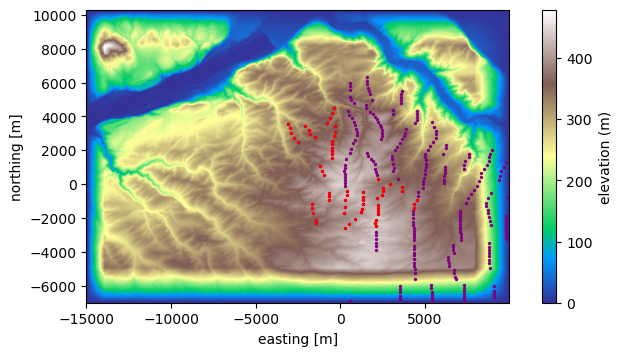

In [45]:
fig,ax = plt.subplots(figsize=(7,3.8))

cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='elevation (m)')

ax.scatter(turb['xref'], turb['yref'], c='purple', s=2)
ax.scatter(turbsOI['xref'], turbsOI['yref'], c='red', s=2)

domainbox = Rectangle((xminLES,yminLES), xmaxLES-xminLES, ymaxLES-yminLES, edgecolor='r', lw=3 , facecolor='none')

ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]')
ax.axis('scaled')

# Comment out one of the two lines below
ax.set_xlim([xminLES,xmaxLES]);  ax.set_ylim([yminLES,ymaxLES])
#ax.add_patch(domainbox)  # to add the red box around the LES domain

plt.show()

## 2.6. Generate VTK with turbine disks for visualization purposes

In [46]:
import pyvista as pv

for i, (t, row) in enumerate(turbsOI.iterrows()):
        newDisk = pv.Disc(center=(row['xref'], row['yref'], row['zref']+row['t_hh']),inner=8, outer=row['t_rd']/2, normal=(1.0, 0.0,0.0), r_res=1, c_res=24)

        if(i==0): globalBox = newDisk
        else:     globalBox = globalBox.merge([newDisk])
            
    
data = np.column_stack([turbsOI['xref'].values, turbsOI['yref'].values, turbsOI['zref'].values+turbsOI['t_hh'].values])
mesh1 = pv.PolyData(data)

pl = pv.Plotter() 
pl.add_mesh(mesh1, render_points_as_spheres=True, point_size=10)      

pv.save_meshio(os.path.join(basepath, 'turbines_for_visualization.vtk'), globalBox)

/home/rthedin/.conda-envs/ssrs_env/lib/python3.11/site-packages/pyvista/plotting/plotter.py:151: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


# 3. Generate AMR-Wind Input File

## 3.1. User Input

In [47]:
incflo_velocity_hh = (8, 0, 0)      # incflow velocity at hub height
res_lvl0 = 40                       # Resolution of level 0
zhi = 2080                          # Top of the domain. Bottom is at 0

In [48]:
ang = np.rad2deg(math.atan2(incflo_velocity_hh[1], incflo_velocity_hh[0]))
wdir = (270 - ang)%360

## 3.2. Domain info

In [49]:
amrinfo_domain = os.path.join(amrdir, 'domain_info.i')

In [50]:
n_cellx = extentx/res_lvl0
n_celly = extenty/res_lvl0
n_cellz = zhi/res_lvl0

print(f'The number of cells for the domain specified, given a level 0 resolution of {res_lvl0} m is ({n_cellx} {n_celly} {n_cellz})')

The number of cells for the domain specified, given a level 0 resolution of 40 m is (624.0 432.0 52.0)


In [51]:
fid = open(amrinfo_domain, 'w')

fid.write(f'geometry.prob_lo        =  {xminLES} {yminLES}    0.  # Lo corner coordinates\n')
fid.write(f'geometry.prob_hi        =  {xmaxLES} {ymaxLES}  {zhi}.  # Hi corner coordinates\n')
fid.write(f'amr.n_cell              =  {int(n_cellx)} {int(n_celly)} {int(n_cellz)} # Grid cells at coarsest AMRlevel\n')
fid.write(f'\n')
fid.write(f'incflo.velocity         = {incflo_velocity_hh[0]} {incflo_velocity_hh[1]} {incflo_velocity_hh[2]} \n')

fid.close()

In [52]:
if len(turbsOI['t_hh'].unique()) != 1:
    raise ValueError (f"Turbines of different hub heights present. Not sure what to set the BLForcing.abl_forcing_height to.")
    
    
fid = open(os.path.join(amrdir, 'setup_main.i'), 'w')
fid.write(f"time.stop_time            =   20000.0\n\n")

fid.write(f"#¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨#\n")
fid.write(f"#               PHYSICS                 #\n")
fid.write(f"#.......................................#\n")
fid.write(f'incflo.velocity         = {incflo_velocity_hh[0]} {incflo_velocity_hh[1]} {incflo_velocity_hh[2]} \n\n')

fid.write(f"ABLForcing.abl_forcing_height     = {turbsOI['t_hh'].unique()[0]}\n\n")

fid.write(f"CoriolisForcing.latitude      = 45.66  # wfip2\n")
fid.write(f"CoriolisForcing.north_vector  = 0.0 1.0 0.0\n")
fid.write(f"CoriolisForcing.east_vector   = 1.0 0.0 0.0\n\n")

fid.write(f"incflo.physics = ABL # Actuator\n\n")



fid.write(f"#¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨¨#\n")
fid.write(f"#            GEOMETRY & BCs             #\n")
fid.write(f"#.......................................#\n")
fid.write(f'amr.n_cell              =  {int(n_cellx)} {int(n_celly)} {int(n_cellz)} # Grid cells at coarsest AMRlevel\n')

fid.write(f'geometry.prob_lo          =  {xminLES} {yminLES}    0.  # Lo corner coordinates\n')
fid.write(f'geometry.prob_hi          =  {xmaxLES} {ymaxLES}  {zhi}.  # Hi corner coordinates\n')
fid.write(f"geometry.is_periodic      =   1   1   0  \n\n")



fid.close()


## 3.3. Turbine info

In [53]:
amrinfo_turb_jouk = os.path.join(amrdir, 'turbine_info_joukowsky.i')

In [54]:
fid = open(amrinfo_turb_jouk, 'w')

fid.write('Actuator.labels = ')
for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'Turb{i+1}  ')
fid.write('\nActuator.type = JoukowskyDisk\n\n')

fid.write(f'Actuator.JoukowskyDisk.epsilon        = 5.0 5.0 5.0\n')
fid.write(f'Actuator.JoukowskyDisk.yaw            = {wdir}\n')
fid.write(f'Actuator.JoukowskyDisk.output_frequency = 100\n')
fid.write(f'Actuator.JoukowskyDisk.diameters_to_sample = 2.5\n')
fid.write(f'Actuator.JoukowskyDisk.thrust_coeff  = 1.158093814 0.958191954 0.842281443 0.841410733 0.841410733 0.841410733 0.841410733 0.841410733 0.841410733 0.841410733 0.841410733 0.841410733 0.784534886 0.743327664 0.653457742 0.566093507 0.485349168 0.448263929 0.387457153 0.293997037 0.226171155 0.176059266   0.13865674 0.110481935 0.089183188 0.072941144 0.060464209 0.05074999 0.043180894 0.037323406\n')
fid.write(f'Actuator.JoukowskyDisk.wind_speed  = 3.0 3.889649963239854 4.684006996752303 5.377830233987229 5.966542092267928 6.44625847394617 6.8138143922059236 7.066784852  7.203500851477444 7.22306038896904 7.320786359429763 7.535153078939617 7.864746237154081 8.30739130337076 8.860167873258558 9.519428936578247 10.280  10.681872976809931 11.13933247768231 12.08928744604103 13.12442240111568 14.237907914913496 15.422397632159566 16.670076738763772 17.972713521 19.321713675239476 20.708177009893884 22.122956165519163 23.556716965618207 25.0\n')
fid.write(f'Actuator.JoukowskyDisk.rpm            = 8 8 8 9.172052607 10.17611854 10.99428938 11.62116715 12.05261594 12.28578923 12.31914861 12.48582322 12.85143216 13.413563 14.16850788 15.11128509 15.16026965 15.16026965 15.16026965 15.16026965 15.16026965 15.16026965 15.16026965 15.16026965 15.16026965 15.16026965 15.16026  15.16026965 15.16026965 15.16026965 15.16026965\n')
fid.write(f'Actuator.JoukowskyDisk.num_points_r   = 5\n')
fid.write(f'Actuator.JoukowskyDisk.num_points_t   = 5\n')
fid.write(f'Actuator.JoukowskyDisk.num_blades     = 3\n')
fid.write(f'Actuator.JoukowskyDisk.vortex_core_size = 13.0\n')
fid.write(f'Actuator.JoukowskyDisk.use_tip_correction = true\n')
fid.write(f'Actuator.JoukowskyDisk.use_root_correction = true\n\n')

for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'# Turbine {i+1}: USWTDB {row.p_name} turbine {row.t_manu} {row.t_model}, ID number {row.case_id} \n')
    fid.write(f'Actuator.Turb{i+1}.base_position  = {row.xref:.4f} {row.yref:.4f} {row.zref:.4f}\n')
    fid.write(f'Actuator.Turb{i+1}.rotor_diameter = {row.t_rd}\n')
    fid.write(f'Actuator.Turb{i+1}.hub_height     = {row.t_hh}\n\n')

fid.close()

In [55]:
amrinfo_turb_alm = os.path.join(amrdir, 'turbine_info_alm.i')

In [56]:
amrinfo_turb_alm = os.path.join(amrdir, 'turbine_info_alm.i')

# TONY:
# R = 46 m for SWT-2.3
# Let's say number of actuators N=40, so DR = R/N = 46/40 = 1.15
# Near-blade resolution DX=2.5
# Acccording to Matt, eps/D should be 0.35, so say eps=5 or 6
# For good convergence, eps/DX > 4. Our eps/DX is 5/2.5=2 (which is not >4, so we are not good)
# For good convergence, eps/DR > 1. Our eps/DR is 5/1.15=4.x (which is >1, so we are good)

fid = open(amrinfo_turb_alm, 'w')

fid.write('Actuator.labels = ')
for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'Turb{i+1} ')
fid.write('\nActuator.type = TurbineFastLine\n\n')

fid.write(f'Actuator.TurbineFastLine.num_points_blade    = 40\n')
fid.write(f'Actuator.TurbineFastLine.num_points_tower    = 15\n')
fid.write(f'Actuator.TurbineFastLine.epsilon             = 16 16 16  # for 2.5m near-blade resolution\n')
fid.write(f'Actuator.TurbineFastLine.epsilon_tower       = 10 10 10\n')
fid.write(f'Actuator.TurbineFastLine.nacelle_drag_coeff  = 0.5\n')
fid.write(f'Actuator.TurbineFastLine.nacelle_area        = 49.5\n')
fid.write(f'Actuator.TurbineFastLine.output_frequency    = 10\n')
fid.write(f'Actuator.TurbineFastLine.density             = 1.225\n')
fid.write(f'Actuator.TurbineFastLine.openfast_start_time = 0.0\n')
fid.write(f'Actuator.TurbineFastLine.openfast_stop_time  = 3601.0\n\n')


for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'# Turbine {i+1}: USWTDB {row.p_name} turbine {row.t_manu} {row.t_model}, ID number {row.case_id} \n')
    fid.write(f'Actuator.Turb{i+1}.base_position  = {row.xref:.4f} {row.yref:.4f} {row.zref:.4f}\n')
    fid.write(f'Actuator.Turb{i+1}.rotor_diameter = {row.t_rd}\n')
    fid.write(f'Actuator.Turb{i+1}.hub_height     = {row.t_hh}\n')
    fid.write(f'Actuator.Turb{i+1}.openfast_input_file = turbine_swt2.3_of3.4/SWT-2.3-93OpenFAST2_R2.T{i+1}.fst\n\n')

fid.close()

In [57]:
amrinfo_turb_alm_fllc = os.path.join(amrdir, 'turbine_info_alm_fllc.i')

fid = open(amrinfo_turb_alm_fllc, 'w')

fid.write('Actuator.labels = ')
for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'Turb{i+1} ')
fid.write('\nActuator.type = TurbineFastLine\n\n')

fid.write(f'Actuator.TurbineFastLine.num_points_blade    = 93\n')
fid.write(f'Actuator.TurbineFastLine.num_points_tower    = 15\n') # number of points from the aerodyn file NumTwrNds

fid.write(f'Actuator.TurbineFastLine.epsilon             = 10 10 10  # for 2.5m near-blade resolution\n')

fid.write(f'Actuator.TurbineFastLine.fllc = 1\n')
fid.write(f'Actuator.TurbineFastLine.fllc_nonuniform = 1\n')
fid.write(f'Actuator.TurbineFastLine.fllc_eps_dr = 3\n')
fid.write(f'# Actuator.TurbineFastLine.fllc_start_time = 5\n')

fid.write(f'Actuator.TurbineFastLine.epsilon_tower       = 10 10 10\n')

fid.write(f'Actuator.TurbineFastLine.nacelle_drag_coeff  = 0.5\n')
fid.write(f'Actuator.TurbineFastLine.nacelle_area        = 49.5\n')
fid.write(f'Actuator.TurbineFastLine.output_frequency    = 10\n')
fid.write(f'Actuator.TurbineFastLine.density             = 1.225\n')
fid.write(f'Actuator.TurbineFastLine.openfast_start_time = 0.0\n')
fid.write(f'Actuator.TurbineFastLine.openfast_stop_time  = 3601.0\n\n')


for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'# Turbine {i+1}: USWTDB {row.p_name} turbine {row.t_manu} {row.t_model}, ID number {row.case_id} \n')
    fid.write(f'Actuator.Turb{i+1}.base_position  = {row.xref:.4f} {row.yref:.4f} {row.zref:.4f}\n')
    fid.write(f'Actuator.Turb{i+1}.rotor_diameter = {row.t_rd}\n')
    fid.write(f'Actuator.Turb{i+1}.hub_height     = {row.t_hh}\n')
    fid.write(f'Actuator.Turb{i+1}.openfast_input_file = turbine_swt2.3_of3.4/SWT-2.3-93OpenFAST2_R2.T{i+1}.fst\n\n')

fid.close()

## 3.4. Refinement regions info

In [58]:
amrinfo_ref = os.path.join(amrdir, 'refinement_info.i')

In [59]:
def createRotatedBoxRefinement(points, angle_degrees, bottom, top, right, left):
    '''
    Creates the box refinement for amr-wind around the convex hull of points
    given. The box is rotated by a certain angle.
    
    Inputs
    ------
    angle_degrees: scalar
        angle to rotate the whole bounding box (typically the wind direction)
    bottom, top, right, left: scalars
        The fringe amount on each side from the bounding box
        
    '''
    
    # Angle to rotate the bounding box
    angle_radians = np.deg2rad(angle_degrees)
    


    def rotate_points(points, angle):
        rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                                    [np.sin(angle), np.cos(angle)]])
        return np.dot(points, rotation_matrix.T)

    def bounding_box(points):
        min_x, min_y = np.min(points, axis=0)
        max_x, max_y = np.max(points, axis=0)
        return np.array([[min_x, min_y],
                         [max_x, min_y],
                         [max_x, max_y],
                         [min_x, max_y]])

    
    # For multiple turbines, get the hull
    if len(points) > 1:
        # Get convex hull
        from scipy.spatial import ConvexHull
        hull = ConvexHull(points)
        # Extract the points of the convex hull
        hull_points = points[hull.vertices]
        # Rotate the convex hull points
        rotated_hull_points = rotate_points(hull_points, angle_radians)
        # Find the axis-aligned bounding box of the rotated points
        bbox_rotated = bounding_box(rotated_hull_points)
        
        
    # For single turbine (single point), use the point as is
    else:
        rotated_hull_points = rotate_points(points, angle_radians)
        bbox_rotated = rotated_hull_points
        hull = None

    
    # Expand the bounding box
    min_x, min_y = np.min(bbox_rotated, axis=0)
    max_x, max_y = np.max(bbox_rotated, axis=0)

    expanded_bbox_rotated = np.array([[min_x - left, min_y - bottom],
                                      [max_x + right, min_y - bottom],
                                      [max_x + right, max_y + top],
                                      [min_x - left, max_y + top]])

    # Rotate the bounding box back to the original coordinate system
    bbox = rotate_points(expanded_bbox_rotated, -angle_radians)

    # Determine the parameters needed for amr-wind refinement
    origin = bbox[0]
    xaxis = bbox[1] - bbox[0]
    yaxis = bbox[3] - bbox[0]
    
    return hull, bbox, origin, xaxis, yaxis

In [60]:
# Create level 1 ref around all turbines
points1 = np.vstack([turbsOI['xref'].values, turbsOI['yref'].values]).T
hull1, bbox1, origin1, xaxis1, yaxis1 =  createRotatedBoxRefinement(points1, 
                                                                   angle_degrees=ang,
                                                                   bottom=1500,
                                                                   top=1500,
                                                                   right=2000,
                                                                   left=3000)

# Create level 2 ref around all turbines
points2 = np.vstack([turbsOI['xref'].values, turbsOI['yref'].values]).T
hull2, bbox2, origin2, xaxis2, yaxis2 =  createRotatedBoxRefinement(points2, 
                                                                   angle_degrees=ang,
                                                                   bottom=600,
                                                                   top=600,
                                                                   right=1000,
                                                                   left=2000)

In [61]:
# LARGER REFINEMENTS
amrinfo_ref = os.path.join(amrdir, 'refinement_info_larger_level1.i')

# Create level 1 ref around all turbines
points1 = np.vstack([turbsOI['xref'].values, turbsOI['yref'].values]).T
hull1, bbox1, origin1, xaxis1, yaxis1 =  createRotatedBoxRefinement(points1, 
                                                                   angle_degrees=ang,
                                                                   bottom=3000,
                                                                   top=2000,
                                                                   right=2000,
                                                                   left=5000)

# Create level 2 ref around all turbines
points2 = np.vstack([turbsOI['xref'].values, turbsOI['yref'].values]).T
hull2, bbox2, origin2, xaxis2, yaxis2 =  createRotatedBoxRefinement(points2, 
                                                                   angle_degrees=ang,
                                                                   bottom=600,
                                                                   top=600,
                                                                   right=1000,
                                                                   left=2000)

In [62]:
fid = open(amrinfo_ref, 'w')

fid.write('amr.max_level = 4\n\n')

fid.write(f'#---- tagging defs ----\n')
fid.write(f'tagging.labels                           = Tall_lvl_0to1 Tall_lvl_1to2 ')
for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f' T{i+1}_lvl_2to3')
for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f' T{i+1}_lvl_3to4')
fid.write('\n\n')


startref = 200
fid.write(f'# Refinement level 0 to 1 spanning the whole Biglow Canyon I farm\n')
fid.write(f'tagging.Tall_lvl_0to1.type               = GeometryRefinement\n')
fid.write(f'tagging.Tall_lvl_0to1.shapes             = Tall_lvl_0to1\n')
fid.write(f'tagging.Tall_lvl_0to1.level              = 0\n')
fid.write(f'tagging.Tall_lvl_0to1.Tall_lvl_0to1.type   = box\n')
fid.write(f'tagging.Tall_lvl_0to1.Tall_lvl_0to1.origin = {origin1[0]:.4f} {origin1[1]:.4f} {startref} \n')
fid.write(f'tagging.Tall_lvl_0to1.Tall_lvl_0to1.xaxis  = {xaxis1[0]:.4f} {xaxis1[1]:.4f} 0.0\n')
fid.write(f'tagging.Tall_lvl_0to1.Tall_lvl_0to1.yaxis  = {yaxis1[0]:.4f} {yaxis1[1]:.4f} 0.0\n')
fid.write(f"tagging.Tall_lvl_0to1.Tall_lvl_0to1.zaxis  = 0.0 0.0 {turbsOI['zref'].max()+turbsOI['t_hh'].max()+7*turbsOI['t_rd'].max():.4f}\n")
fid.write(f'\n')
fid.write(f'# Refinement level 1 to 2 spanning the whole Biglow Canyon I farm\n')
fid.write(f'tagging.Tall_lvl_1to2.type               = GeometryRefinement\n')
fid.write(f'tagging.Tall_lvl_1to2.shapes             = Tall_lvl_1to2\n')
fid.write(f'tagging.Tall_lvl_1to2.level              = 1\n')
fid.write(f'tagging.Tall_lvl_1to2.Tall_lvl_1to2.type   = box\n')
fid.write(f'tagging.Tall_lvl_1to2.Tall_lvl_1to2.origin = {origin2[0]:.4f} {origin2[1]:.4f} {startref} \n')
fid.write(f'tagging.Tall_lvl_1to2.Tall_lvl_1to2.xaxis  = {xaxis2[0]:.4f} {xaxis2[1]:.4f} 0.0\n')
fid.write(f'tagging.Tall_lvl_1to2.Tall_lvl_1to2.yaxis  = {yaxis2[0]:.4f} {yaxis2[1]:.4f} 0.0\n')
fid.write(f"tagging.Tall_lvl_1to2.Tall_lvl_1to2.zaxis  = 0.0 0.0 {turbsOI['zref'].max()+turbsOI['t_hh'].max()+5*turbsOI['t_rd'].max():.4f}\n")
fid.write(f'\n')
    

for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'# Refinement level 2 to 3 for turbine {i+1}: USWTDB {row.p_name} turbine {row.t_manu} {row.t_model}, ID number {row.case_id} \n')
    pointsT = np.vstack([row['xref'], row['yref']]).T
    _, bboxT, originT, xaxisT, yaxisT =  createRotatedBoxRefinement(pointsT, angle_degrees=ang,
                                                                    bottom=2*row.t_rd, top= 2*row.t_rd,
                                                                    right= 4*row.t_rd, left=4*row.t_rd)
    
    fid.write(f'tagging.T{i+1}_lvl_2to3.type                 = GeometryRefinement\n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.shapes               = T{i+1}_lvl_2to3\n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.level                = 2\n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.T{i+1}_lvl_2to3.type     = box\n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.T{i+1}_lvl_2to3.origin   = {originT[0]:.4f} {originT[1]:.4f} {row.zref} \n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.T{i+1}_lvl_2to3.xaxis    = {xaxisT[0]:.4f} {xaxisT[1]:.4f} 0.0\n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.T{i+1}_lvl_2to3.yaxis    = {yaxisT[0]:.4f} {yaxisT[1]:.4f} 0.0\n')
    fid.write(f'tagging.T{i+1}_lvl_2to3.T{i+1}_lvl_2to3.zaxis    = 0.0 0.0 {row.t_hh+row.t_rd*2}\n')
    fid.write(f'\n')


    
    
for i, (t, row) in enumerate(turbsOI.iterrows()):
    fid.write(f'# Refinement level 2 to 3 for turbine {i+1}: USWTDB {row.p_name} turbine {row.t_manu} {row.t_model}, ID number {row.case_id} \n')
    pointsT = np.vstack([row['xref'], row['yref']]).T
    _, bboxT, originT, xaxisT, yaxisT =  createRotatedBoxRefinement(pointsT, angle_degrees=ang,
                                                                    bottom=1*row.t_rd, top= 1*row.t_rd,
                                                                    right= 2*row.t_rd, left=2*row.t_rd)
    
    fid.write(f'tagging.T{i+1}_lvl_3to4.type                = GeometryRefinement\n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.shapes              = T{i+1}_lvl_3to4\n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.level               = 3\n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.T{i+1}_lvl_3to4.type     = box\n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.T{i+1}_lvl_3to4.origin   = {originT[0]:.4f} {originT[1]:.4f} {row.zref} \n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.T{i+1}_lvl_3to4.xaxis    = {xaxisT[0]:.4f} {xaxisT[1]:.4f} 0.0\n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.T{i+1}_lvl_3to4.yaxis    = {yaxisT[0]:.4f} {yaxisT[1]:.4f} 0.0\n')
    fid.write(f'tagging.T{i+1}_lvl_3to4.T{i+1}_lvl_3to4.zaxis    = 0.0 0.0 {row.t_hh+row.t_rd*1}\n')
    fid.write(f'\n')
    
    
fid.close()

### 3.4.1. Visualization

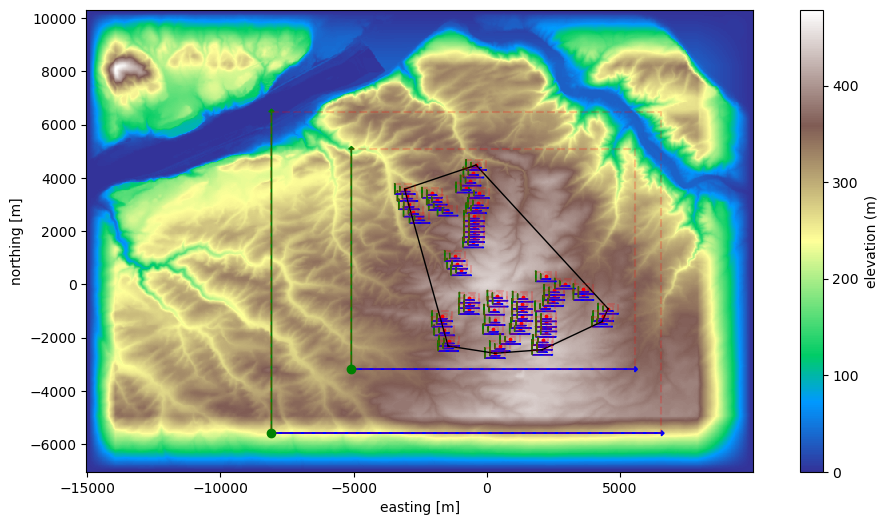

In [63]:
fig,ax = plt.subplots(figsize=(12,6))

cm = ax.pcolormesh(xxstl, yystl, zstl, shading='auto', cmap='terrain')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='elevation (m)')

# Plot turbines
ax.scatter(turbsOI['xref'], turbsOI['yref'], c='red', s=3)

# Plot convex hull around turbines
for simplex in hull1.simplices:
    plt.plot(points1[simplex, 0], points1[simplex, 1], 'k-', lw=1)
    
# Plot refinement level 1
plt.plot(np.append(bbox1[:, 0], bbox1[0, 0]),
         np.append(bbox1[:, 1], bbox1[0, 1]), 'r--', alpha=0.2)
# Plot the origin, xaxis, and yaxis
plt.plot( origin1[0], origin1[1], 'go')  # Origin
plt.arrow(origin1[0], origin1[1], xaxis1[0], xaxis1[1], head_width=200, head_length=100, fc='blue', ec='blue')
plt.arrow(origin1[0], origin1[1], yaxis1[0], yaxis1[1], head_width=200, head_length=100, fc='green', ec='green')

# Plot refinement level 2
plt.plot(np.append(bbox2[:, 0], bbox2[0, 0]),
         np.append(bbox2[:, 1], bbox2[0, 1]), 'r--', alpha=0.2)
# Plot the origin, xaxis, and yaxis
plt.plot( origin2[0], origin2[1], 'go')  # Origin
plt.arrow(origin2[0], origin2[1], xaxis2[0], xaxis2[1], head_width=200, head_length=100, fc='blue', ec='blue')
plt.arrow(origin2[0], origin2[1], yaxis2[0], yaxis2[1], head_width=200, head_length=100, fc='green', ec='green')


# Plot refinement level 3 on all turbines
for i, (t, row) in enumerate(turbsOI.iterrows()):
    pointsT = np.vstack([row['xref'], row['yref']]).T
    _, bboxT, originT, xaxisT, yaxisT =  createRotatedBoxRefinement(pointsT,angle_degrees=ang,
                                                                    bottom=2*row.t_rd, top= 2*row.t_rd,
                                                                    right= 4*row.t_rd, left=4*row.t_rd)
    plt.plot(np.append(bboxT[:, 0], bboxT[0, 0]),
         np.append(bboxT[:, 1], bboxT[0, 1]), 'r--', alpha=0.2)
    # Plot the origin, xaxis, and yaxis
    #plt.plot( originT[0], originT[1], 'g*')  # Origin
    plt.arrow(originT[0], originT[1], xaxisT[0], xaxisT[1], head_width=40, head_length=20, fc='blue', ec='blue')
    plt.arrow(originT[0], originT[1], yaxisT[0], yaxisT[1], head_width=40, head_length=20, fc='green', ec='green')

    
    
# Plot refinement level 4 on all turbines
for i, (t, row) in enumerate(turbsOI.iterrows()):
    pointsT = np.vstack([row['xref'], row['yref']]).T
    _, bboxT, originT, xaxisT, yaxisT =  createRotatedBoxRefinement(pointsT,angle_degrees=ang,
                                                                    bottom=1*row.t_rd, top= 1*row.t_rd,
                                                                    right= 2*row.t_rd, left=2*row.t_rd)
    plt.plot(np.append(bboxT[:, 0], bboxT[0, 0]),
         np.append(bboxT[:, 1], bboxT[0, 1]), 'r--', alpha=0.2)
    # Plot the origin, xaxis, and yaxis
    #plt.plot( originT[0], originT[1], 'g*')  # Origin
    plt.arrow(originT[0], originT[1], xaxisT[0], xaxisT[1], head_width=20, head_length=10, fc='blue', ec='blue')
    plt.arrow(originT[0], originT[1], yaxisT[0], yaxisT[1], head_width=20, head_length=10, fc='green', ec='green')

    
ax.set_xlabel('easting [m]');  ax.set_ylabel('northing [m]')
ax.set_aspect('equal')

plt.show()

# 4. Generate FAST.Farm turbulent boxes input for AMR-Wind

In [64]:
# ----------- General hard-coded parameters
#cmax     = 3.1     # maximum blade chord (m) for the V82
cmax     = 3.35     # maximum blade chord (m) for the SWT-2.3-93
#fmax     = 10/6   # maximum excitation frequency (Hz)
fmax     = 5   # controls the dt. I want dt=0.1 to match LES, so I will set the appropriate fmax. dt=1/(2f). 
Cmeander = 1.9    # Meandering constant (-)
mod_wake = 1      # Polar

# ----------- Wind farm
wts={}
for i, (t, row) in enumerate(turbsOI.iterrows()):
    wts[i] = {'x':row['xref'],  'y':row['yref'],  'z':row['zref'],  'D':row['t_rd'],  'zhub':row['t_hh'],  'cmax':cmax,  'fmax':fmax,  'Cmeander':Cmeander}
refTurb_rot = 0

# ----------- Low- and high-res boxes parameters (should match LES if comparisons are to be made; otherwise, desired values)
buffer_lr = [2.5,6,2.5,2.5,2]
buffer_hr = 0.6

# ----------- AMR-Wind parameters
fixed_dt = 0.05
prob_lo =  (xminLES, yminLES, 0.0)
prob_hi =  (xmaxLES, ymaxLES,  zhi) 
n_cell  =  (int(n_cellx), int(n_celly), int(n_cellz))   # 40 m level 0
max_level = 4  # Number of grid refinement levels

incflo_velocity_hh = incflo_velocity_hh  # Hub-height velocity; set previously
postproc_name = 'box'

# Levels of each box
level_lr=2
level_hr=4

# Because the zlo is zero, the low-res box will start at 0 and go all the way to top of highest turbine plus the buffer
# So in reality, it is much larger than it needs to be, but that is okay.

In [65]:
# For the Siemens SWT-2.3-93

amr = AMRWindSimulation(wts, fixed_dt, prob_lo, prob_hi,
                        n_cell, max_level, incflo_velocity_hh,
                        postproc_name, buffer_lr = buffer_lr, buffer_hr=buffer_hr,
                        ds_hr=None,
                        ds_lr=10,
                        dt_hr=0.5,
                        dt_lr=2,
                        mod_wake=mod_wake,
                        level_lr=level_lr, level_hr=level_hr)

print(f'The high-res spatial resolution is {amr.ds_hr} m,  and the low-res spatial resolution is {amr.ds_lr} m')
print(f'The high-res temporal resolution is {amr.dt_high_les} s, and the low-res temporal resolution is {amr.dt_low_les} s')

--- WARNING: LOW-RES SPATIAL RESOLUTION GIVEN. CONVERTING FATAL ERRORS ON LOW-RES BOX CHECKS TO WARNINGS. ---


The high-res spatial resolution is 2.5 m,  and the low-res spatial resolution is 10 m
The high-res temporal resolution is 0.5 s, and the low-res temporal resolution is 2 s


In [66]:
# Write to file. If you want to write to screen instead, just remove the arguments from the call below.
amr.write_sampling_params(amrdir, overwrite=True)

In [67]:
casepath = '/projects/total/Mathias2024/FASTFarm/terrain_geo_gpu_level4'

In [ ]:
ppp = '/home/rthedin/fastfarm/total_demonstration/total_boxes_processing_biglow3_swt'
low_samplingboxfile  = 'box_lr06703.nc'
high_samplingboxfile = 'box_hr06703.nc'

# but the test boxes have a different dt:
fixed_dt = 0.1

In [ ]:
# first 600 seconds
low_samplingboxfile  = 'box_lr46703.nc'
high_samplingboxfile = 'box_hr46703.nc'
# next 600 seconds
# low_samplingboxfile  = 'box_lr58703.nc'
# high_samplingboxfile = 'box_hr58703.nc'
# # next 600 seconds
# low_samplingboxfile  = 'box_lr70703.nc'
# high_samplingboxfile = 'box_hr70703.nc'

fixed_dt = 0.05
ppp = '/home/rthedin/fastfarm/total_demonstration/total_boxes_processing_biglow3_swt_realrun'

### Low-res

In [ ]:
samplingboxpath = os.path.join(casepath,'post_processing',low_samplingboxfile)
s_low = Sampling(samplingboxpath)

In [ ]:
s_low

In [ ]:
ds = s_low.to_vtk('Low',
             outputPath = os.path.join(ppp,'processedData','Low'),
             t0=24222.57777,
             dt=40*fixed_dt,
             itime_i = 0, itime_f = 100, # 300 timesteps for 600 s
             terrain=True,
            )

In [ ]:
dslow = s_low.read_single_group('Low',itime=0, ftime=10, outputPath=None, simCompleted=True, var=['velocityx', 'velocityy', 'velocityz', 'mu_turb'])

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

yy, zz = np.meshgrid(dslow.y, dslow.z, indexing='ij')

cm = ax.pcolormesh(yy, zz, dslow.isel(samplingtimestep=0, x=400)['u'], shading='auto', cmap='viridis')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='u [m/s]')

### High-res

In [ ]:
samplingboxpath = os.path.join(casepath,'post_processing',high_samplingboxfile)
s_high = Sampling(samplingboxpath)

In [ ]:
for t in range(1,65+1):
    outp = os.path.join(ppp,'processedData',f'HighT{t}_inflow0deg')
    os.makedirs(outp,exist_ok=True)
    s_high.to_vtk(f'HighT{t}_inflow0deg',
                  outputPath = outp,
                  t0=24222.57777,
                  dt=10*fixed_dt,
                  itime_i=4*0, itime_f=4*300,
                  terrain=True)

### Check ABL stat from flat-terrain precursor

In [ ]:
from windtools.plotting import plot_profile
from windtools.amrwind.post_processing  import ABLStatistics
sys.path.append(os.path.abspath('/home/rthedin/utilities/'))
from helper import calc_QOIs
from mmctools.helper_functions import fit_powerlaw

In [ ]:
precpath = '/projects/total/Mathias2024/FASTFarm/precursor_Geo'

In [ ]:
ablstat1 = os.path.join(precpath,'post_processing','abl_statistics00000.nc')
ablstat2 = os.path.join(precpath,'post_processing','abl_statistics06703.nc')

In [ ]:
abl1 = ABLStatistics(ablstat1, mean_profiles=True)
abl2 = ABLStatistics(ablstat2, mean_profiles=True)

df1 = abl1.ds.to_dataframe()
df2 = abl2.ds.to_dataframe()

calc_QOIs(df1,code='amr')
calc_QOIs(df2,code='amr')
ds1 = df1.to_xarray()
ds2 = df2.to_xarray()

#ds = ds1.copy()
ds = xr.concat([ds1,ds2], dim='time')

In [ ]:
# Get Power law exponent 
zref = 100
alpha, r = fit_powerlaw(df=ds.sel(height=slice(20,160))['hvelmag'].to_dataframe().unstack(level='time'), zref=zref) #columns should be datetime!!
ds['alpha'] = (('time'), alpha.values)

# Calculate veer
ds = calc_veer(ds, between_height=[40,250])

In [ ]:
# Interval of iterest
ti = 5000
tf = 25000

timesToPlot = ds['time'].sel(time=slice(ti,tf,10)).values

fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(12,8), gridspec_kw={'hspace':0.25})
fig,ax = plot_profile(
    ds, #ds.ds,
    fields=["hvelmag","u","theta","TI_pavg","w'theta'_r","u'w'_r","v'w'_r", "TKE"],
    times=timesToPlot,
    showlegend=True,
    labelsubplots=True,
    #heightlimits=[0,1100],
    cmap='viridis',
    fig=fig, ax=ax
)

#ax[0,1].set_xlim([-3.5,0.4])
plt.show()

#fig.savefig(os.path.join(figpath, f'vert_profiles_{ti}_{tf}.png'), bbox_inches='tight', dpi=150)

In [ ]:
avgalpha = ds['alpha'].sel( time=slice(ti, tf)).mean().values
avgtitke = ds['TI_TKE_Uhor'].sel(time=slice(ti, tf), height=zref).mean().values*100
avgustar = ds['ustar'].sel(time=slice(ti, tf), height=zref).mean().values
avgveer  = ds['veer_deg_per_m'].sel(time=slice(ti, tf)).mean().values


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,7), gridspec_kw={'wspace':0.3})
axs = axs.flatten()

axs[0].plot(ds['time'], ds['alpha'])
axs[0].set_ylabel('shear exponent [-]')
#axs[0].set_ylim([0.15, 0.34])
#axs[0].set_xlim([14000,35000])

axs[1].plot(ds['time'], ds['TI_TKE_Uhor'].sel(height=zref), label='TI based on TKE')
axs[1].legend()
axs[1].set_ylabel('TI [-]')

axs[2].plot(ds['time'], ds['ustar'].isel(height=0))
axs[2].set_ylabel('ustar [m/s]')

axs[3].plot(ds['time'], ds['veer_deg_per_m'])
axs[3].set_ylabel('veer [deg/m]')

axs[0].text(tf, avgalpha,     f'{avgalpha:.4f}',   va='top',    ha='left',  fontsize=12)
axs[1].text(ti, avgtitke/100, f'{avgtitke:.2f}%',  va='top',    ha='right', fontsize=12, c='tab:blue')
axs[2].text(tf, avgustar,     f'{avgustar:.3f}',   va='bottom', ha='left',  fontsize=12)
axs[3].text(tf, avgveer,      f'{avgveer:.6f}',    va='top',    ha='right', fontsize=12)


for ax in axs:
    ax.axvspan(ti, tf, alpha=0.3, color='green')
    ax.set_xlabel('time [s]')
    ax.grid()
    

In [ ]:
casepath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/terrain_level4'

In [ ]:
ppp = '/home/rthedin/fastfarm/total_demonstration/total_boxes_processing_biglow3_swt_2024_08_26'
low_samplingboxfile  = 'box_lr07476.nc'
high_samplingboxfile = 'box_hr07476.nc'
terr_samplingfile    = 'terr07476.nc'

fixed_dt = 0.05

### Low-res

In [ ]:
samplingboxpath = os.path.join(casepath,'post_processing',low_samplingboxfile)
s_low = Sampling(samplingboxpath)

In [ ]:
ds = s_low.to_vtk('Low',
             outputPath = os.path.join(ppp,'processedData','Low'),
             t0=24222.57777,
             dt=40*fixed_dt,
             itime_i = 0, itime_f = 100, # 300 timesteps for 600 s
             terrain=True,
            )

In [ ]:
dslow = s_low.read_single_group('Low',itime=0, ftime=10, outputPath=None, simCompleted=True, var=['velocityx', 'velocityy', 'velocityz', 'mu_turb'])

In [ ]:
fig,ax = plt.subplots(figsize=(8,4))

yy, zz = np.meshgrid(dslow.y, dslow.z, indexing='ij')

cm = ax.pcolormesh(yy, zz, dslow.isel(samplingtimestep=0, x=400)['u'], shading='auto', cmap='viridis')#,vmin=vmin,vmax=vmax)
cb = fig.colorbar(cm,ax=ax, label='u [m/s]')

### High-res

In [ ]:
samplingboxpath = os.path.join(casepath,'post_processing',high_samplingboxfile)
s_high = Sampling(samplingboxpath)

In [ ]:
dshigh_ = s_high.read_single_group('HighT1_inflow0deg',itime=0, ftime=10, step=2)

In [ ]:
dsraw_high = xr.load_dataset(s_high.fpath, group='HighT1_inflow0deg', engine='netcdf4')

In [ ]:
for t in range(1,65+1):
    outp = os.path.join(ppp,'processedData',f'HighT{t}_inflow0deg')
    os.makedirs(outp,exist_ok=True)
    s_high.to_vtk(f'HighT{t}_inflow0deg',
                  outputPath = outp,
                  t0=24222.57777,
                  dt=10*fixed_dt,
                  itime_i=4*0, itime_f=4*300,
                  terrain=True)

### Terrain-following

In [ ]:
from windtools.amrwind.post_processing import Sampling


In [ ]:
casepath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/terrain_level4'
terr_samplingfile    = 'terr07476.nc'

samplingterrpath = os.path.join(casepath,'post_processing',terr_samplingfile)
s_terr = Sampling(samplingterrpath)

In [ ]:
s_terr

In [ ]:
itime=0
ftime=-1
step=1
group='terrain80m'

dsterr_lvl4 = s_terr.read_single_group(group, itime=itime, ftime=ftime, step=step, simCompleted=False)

In [ ]:
ds = s_terr.to_vtk('terrain80m',
             outputPath = os.path.join('/scratch/rthedin'),
             t0=200000,
             dt=2,
             itime_i = 0, itime_f = 5, # 300 timesteps for 600 s
             terrain=True,
            )

In [ ]:
var = 'u'; vmin=2;  vmax=18; cmap='viridis'
#var = 'v'; vmin=-5; vmax=5; cmap='RdBu'
#var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

xx_, yy_ = np.meshgrid(dsterr_lvl4['x'], dsterr_lvl4['y'], indexing='ij')

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl4.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl4[var].isel(samplingtimestep=slice(20, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)




var = 'v'; vmin=-5; vmax=5; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl4.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl4[var].isel(samplingtimestep=slice(20, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)





var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl4.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl4[var].isel(samplingtimestep=slice(20, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)


In [ ]:
casepath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/terrain_level0'

In [ ]:
terr_samplingfile    = 'terr07476.nc'

### Terrain-following

In [ ]:
casepath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/terrain_level0'
terr_samplingfile    = 'terr07476.nc'

samplingterrpath = os.path.join(casepath,'post_processing',terr_samplingfile)
s_terr = Sampling(samplingterrpath)

In [ ]:
itime=0
ftime=-1
step=1
group='terrain80m'

dsterr_lvl0 = s_terr.read_single_group(group, itime=itime, ftime=ftime, step=step, simCompleted=False)

In [ ]:
var = 'u'; vmin=2;  vmax=18; cmap='viridis'
#var = 'v'; vmin=-5; vmax=5; cmap='RdBu'
#var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

xx_, yy_ = np.meshgrid(dsterr_lvl0['x'], dsterr_lvl0['y'], indexing='ij')

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl0.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl0[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)




var = 'v'; vmin=-5; vmax=5; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl0.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl0[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)





var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl0.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl0[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)


In [ ]:
casepath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/terrain_level2'

In [ ]:
terr_samplingfile    = 'terr07476.nc'

### Terrain-following

In [ ]:
casepath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/terrain_level2'
terr_samplingfile    = 'terr07476.nc'

samplingterrpath = os.path.join(casepath,'post_processing',terr_samplingfile)
s_terr = Sampling(samplingterrpath)

In [ ]:
itime=0
ftime=-1
step=1
group='terrain80m'

dsterr_lvl2 = s_terr.read_single_group(group, itime=itime, ftime=ftime, step=step, simCompleted=False)

In [ ]:
var = 'u'; vmin=2;  vmax=18; cmap='viridis'
#var = 'v'; vmin=-5; vmax=5; cmap='RdBu'
#var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

xx_, yy_ = np.meshgrid(dsterr_lvl2['x'], dsterr_lvl2['y'], indexing='ij')

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl2.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl2[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)




var = 'v'; vmin=-5; vmax=5; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl2.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl2[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)





var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl2.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl2[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)


In [ ]:
amrinfo_staticbox = os.path.join(amrdir, 'static_box.txt')

In [ ]:
fid = open(amrinfo_staticbox, 'w')

fid.write(f'2')
fid.write(f'geometry.prob_lo        =  {xminLES} {yminLES} {zmin
fid.write(f'geometry.prob_hi        =  {xmaxLES} {ymaxLES}  {zhi}.  # Hi corner coordinates\n')
fid.write(f'amr.n_cell              =  {int(n_cellx)} {int(n_celly)} {int(n_cellz)} # Grid cells at coarsest AMRlevel\n')
fid.write(f'\n')
fid.write(f'incflo.velocity         = {incflo_velocity_hh[0]} {incflo_velocity_hh[1]} {incflo_velocity_hh[2]} \n')

fid.close()

### Check ABL stat from flat-terrain precursor

In [ ]:
precpath = '/projects/total/Mathias2024/FASTFarm/new_20240823_nocoriolis/precursor'

In [ ]:
ablstat1 = os.path.join(precpath,'post_processing','abl_statistics00000.nc')
ablstat2 = os.path.join(precpath,'post_processing','abl_statistics07476.nc')

In [ ]:
abl1 = ABLStatistics(ablstat1, mean_profiles=True)
abl2 = ABLStatistics(ablstat2, mean_profiles=True)

df1 = abl1.ds.to_dataframe()
df2 = abl2.ds.to_dataframe()

calc_QOIs(df1,code='amr')
calc_QOIs(df2,code='amr')
ds1 = df1.to_xarray()
ds2 = df2.to_xarray()

#ds = ds1.copy()
ds = xr.concat([ds1,ds2], dim='time')

In [ ]:
# Get Power law exponent 
zref = 100
alpha, r = fit_powerlaw(df=ds.sel(height=slice(20,160))['hvelmag'].to_dataframe().unstack(level='time'), zref=zref) #columns should be datetime!!
ds['alpha'] = (('time'), alpha.values)

# Calculate veer
ds = calc_veer(ds, between_height=[40,250])

In [ ]:
# Interval of iterest
ti = 20000
tf = 25000

timesToPlot = ds['time'].sel(time=slice(ti,tf,10)).values

fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(12,8), gridspec_kw={'hspace':0.25})
fig,ax = plot_profile(
    ds, #ds.ds,
    fields=["hvelmag","u","theta","TI_pavg","w'theta'_r","u'w'_r","v'w'_r", "TKE"],
    times=timesToPlot,
    showlegend=True,
    labelsubplots=True,
    #heightlimits=[0,1100],
    cmap='viridis',
    fig=fig, ax=ax
)

#ax[0,1].set_xlim([-3.5,0.4])
plt.show()


In [ ]:
avgalpha = ds['alpha'].sel( time=slice(ti, tf)).mean().values
avgtitke = ds['TI_TKE_Uhor'].sel(time=slice(ti, tf), height=zref).mean().values*100
avgustar = ds['ustar'].sel(time=slice(ti, tf), height=zref).mean().values
avgveer  = ds['veer_deg_per_m'].sel(time=slice(ti, tf)).mean().values


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,7), gridspec_kw={'wspace':0.3})
axs = axs.flatten()

axs[0].plot(ds['time'], ds['alpha'])
axs[0].set_ylabel('shear exponent [-]')
#axs[0].set_ylim([0.15, 0.34])
#axs[0].set_xlim([14000,35000])

axs[1].plot(ds['time'], ds['TI_TKE_Uhor'].sel(height=zref), label='TI based on TKE')
axs[1].legend()
axs[1].set_ylabel('TI [-]')

axs[2].plot(ds['time'], ds['ustar'].isel(height=0))
axs[2].set_ylabel('ustar [m/s]')

axs[3].plot(ds['time'], ds['veer_deg_per_m'])
axs[3].set_ylabel('veer [deg/m]')

axs[0].text(tf, avgalpha,     f'{avgalpha:.4f}',   va='top',    ha='left',  fontsize=12)
axs[1].text(ti, avgtitke/100, f'{avgtitke:.2f}%',  va='top',    ha='right', fontsize=12, c='tab:blue')
axs[2].text(tf, avgustar,     f'{avgustar:.3f}',   va='bottom', ha='left',  fontsize=12)
axs[3].text(tf, avgveer,      f'{avgveer:.6f}',    va='top',    ha='right', fontsize=12)


for ax in axs:
    ax.axvspan(ti, tf, alpha=0.3, color='green')
    ax.set_xlabel('time [s]')
    ax.grid()
    

### Terrain-following

In [ ]:
casepath = '/projects/total/cases/wfip2_acceleration_test_8mps_2024_09_13/level4'
terr_samplingfile    = 'terr01800.nc'

samplingterrpath = os.path.join(casepath,'post_processing',terr_samplingfile)
s_terr = Sampling(samplingterrpath)

In [ ]:
itime=0
ftime=-1
step=1
group='terrain80m'

dsterr_lvl2 = s_terr.read_single_group(group, itime=itime, ftime=ftime, step=step, simCompleted=False)

In [ ]:
var = 'u'; vmin=2;  vmax=14; cmap='viridis'
#var = 'v'; vmin=-5; vmax=5; cmap='RdBu'
#var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

xx_, yy_ = np.meshgrid(dsterr_lvl2['x'], dsterr_lvl2['y'], indexing='ij')

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl2.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl2[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)




var = 'v'; vmin=-5; vmax=5; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl2.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl2[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)





var = 'w'; vmin=-2; vmax=2; cmap='RdBu'

fig, axs = plt.subplots(1,2,figsize=(18, 7))
cm1 = axs[0].pcolormesh(xx_, yy_, dsterr_lvl2.isel(samplingtimestep=-1)[var], vmin=vmin, vmax=vmax, cmap=cmap)
cm2 = axs[1].pcolormesh(xx_, yy_, dsterr_lvl2[var].isel(samplingtimestep=slice(10, None)).mean(dim='samplingtimestep'), vmin=vmin, vmax=vmax, cmap=cmap)
for ax in axs: ax.set_aspect('equal')
cax1 = fig.add_axes([axs[1].get_position().x1+0.02, axs[1].get_position().y0,   # xmin, ymin
                     0.015,                          axs[1].get_position().y1-axs[1].get_position().y0])  # xextent, yextent
cbar1 = fig.colorbar(cm2, cax=cax1, extend='neither')
cbar1.set_label(f'{var} [m/s]', fontsize=14)
cbar1.ax.tick_params(labelsize=14)


In [ ]:
amrinfo_staticbox = os.path.join(amrdir, 'static_box.txt')

In [ ]:
fid = open(amrinfo_staticbox, 'w')

fid.write(f'2')
fid.write(f'geometry.prob_lo        =  {xminLES} {yminLES} {zmin
fid.write(f'geometry.prob_hi        =  {xmaxLES} {ymaxLES}  {zhi}.  # Hi corner coordinates\n')
fid.write(f'amr.n_cell              =  {int(n_cellx)} {int(n_celly)} {int(n_cellz)} # Grid cells at coarsest AMRlevel\n')
fid.write(f'\n')
fid.write(f'incflo.velocity         = {incflo_velocity_hh[0]} {incflo_velocity_hh[1]} {incflo_velocity_hh[2]} \n')

fid.close()

### Check ABL stat from flat-terrain precursor

In [ ]:
precpath = '/projects/total/cases/wfip2_acceleration_test_8mps_2024_09_13/precursor'

In [ ]:
ablstat1 = os.path.join(precpath,'post_processing','abl_statistics00000.nc')
#ablstat2 = os.path.join(precpath,'post_processing','abl_statistics07476.nc')

In [ ]:
abl1 = ABLStatistics(ablstat1, mean_profiles=True)
#abl2 = ABLStatistics(ablstat2, mean_profiles=True)

df1 = abl1.ds.to_dataframe()
#df2 = abl2.ds.to_dataframe()

calc_QOIs(df1,code='amr')
#calc_QOIs(df2,code='amr')
ds1 = df1.to_xarray()
#ds2 = df2.to_xarray()

ds = ds1.copy()
#ds = xr.concat([ds1,ds2], dim='time')

In [ ]:
# Get Power law exponent 
zref = 78.125
alpha, r = fit_powerlaw(df=ds.sel(height=slice(20,160))['hvelmag'].to_dataframe().unstack(level='time'), zref=zref) #columns should be datetime!!
ds['alpha'] = (('time'), alpha.values)

# Calculate veer
ds = calc_veer(ds, between_height=[40,250])

In [ ]:
# Interval of iterest
ti = 20000
tf = 25000

timesToPlot = ds['time'].sel(time=slice(ti,tf,1)).values

fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(12,8), gridspec_kw={'hspace':0.25})
fig,ax = plot_profile(
    ds, #ds.ds,
    fields=["hvelmag","u","theta","TI_pavg","w'theta'_r","u'w'_r","v'w'_r", "TKE"],
    times=timesToPlot,
    showlegend=True,
    labelsubplots=True,
    #heightlimits=[0,1100],
    cmap='viridis',
    fig=fig, ax=ax
)

#ax[0,1].set_xlim([-3.5,0.4])
plt.show()


In [ ]:
avgalpha = ds['alpha'].sel( time=slice(ti, tf)).mean().values
avgtitke = ds['TI_TKE_Uhor'].sel(time=slice(ti, tf), height=zref).mean().values*100
avgustar = ds['ustar'].sel(time=slice(ti, tf), height=zref).mean().values
avgveer  = ds['veer_deg_per_m'].sel(time=slice(ti, tf)).mean().values


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14,7), gridspec_kw={'wspace':0.3})
axs = axs.flatten()

axs[0].plot(ds['time'], ds['alpha'])
axs[0].set_ylabel('shear exponent [-]')
#axs[0].set_ylim([0.15, 0.34])
#axs[0].set_xlim([14000,35000])

axs[1].plot(ds['time'], ds['TI_TKE_Uhor'].sel(height=zref), label='TI based on TKE')
axs[1].legend()
axs[1].set_ylabel('TI [-]')

axs[2].plot(ds['time'], ds['ustar'].isel(height=0))
axs[2].set_ylabel('ustar [m/s]')

axs[3].plot(ds['time'], ds['veer_deg_per_m'])
axs[3].set_ylabel('veer [deg/m]')

axs[0].text(tf, avgalpha,     f'{avgalpha:.4f}',   va='top',    ha='left',  fontsize=12)
axs[1].text(ti, avgtitke/100, f'{avgtitke:.2f}%',  va='top',    ha='right', fontsize=12, c='tab:blue')
axs[2].text(tf, avgustar,     f'{avgustar:.3f}',   va='bottom', ha='left',  fontsize=12)
axs[3].text(tf, avgveer,      f'{avgveer:.6f}',    va='top',    ha='right', fontsize=12)


for ax in axs:
    ax.axvspan(ti, tf, alpha=0.3, color='green')
    ax.set_xlabel('time [s]')
    ax.grid()
    

# 5. Generate the full FAST.Farm setup given LES boxes

## 5.1. User input (Biglow Canyon III, Siemens SWT-2.3-93 turbines)

In [68]:
# Setting up FAST.Farm

# ----------- Case absolute path
path = os.path.join(basepath, 'fastfarm')

# ----------- Additional variables
tmax = 1800
nSeeds = 1
zbot = 1

# ----------- Desired sweeps
inflow_deg = [0]
vhub       = [8]
shear      = [0.1]
TIvalue    = [8] # TI TKE values

# ----------- Turbine parameters
# Set the yaw of each turbine for wind dir. One row for each wind direction. If a sweep of initial yaw for each
# wind direction is desired, then repeat the inflow_deg array and create the extra rows in yaw_init accordingly
yaw_init = None
# Aerodynamic and elastic model
ADmodel = 'ADyn'
EDmodel = 'ED'

# ----------- Site parameters
latitude = 45.66 # wfip2

# ----------- Low- and high-res boxes parameters (should match LES if comparisons are to be made; otherwise, desired values)
# High-res boxes settings
dt_high_les = amr.dt_hr           # sampling frequency of high-res files
ds_high_les = amr.ds_hr           # dx, dy, dz that you want these high-res files at
extent_high = 2*amr.buffer_hr     # high-res box extent in y and x for each turbine, in D. `extent_high` is the total extent; half to each side.
# Low-res boxes settings
dt_low_les  = amr.dt_lr           # sampling frequency of low-res files (must be a multiple of dt_high)
ds_low_les  = amr.ds_lr           # dx, dy, dz of low-res files
extent_low  = amr.buffer_lr       # Extent (buffer) in xmin, xmax, ymin, ymax, zmax directions



# ----------- Execution parameters
ffbin = '/projects/tcwnd/rthedin/repos/openfast_v3.5.3_2024_07_09/openfast/build_walid_release_20240805/install/bin/FAST.Farm'
           
# ----------- LES parameters. The presence of this variable will dictate whether it is a TurbSim-driven or LES-driven case
LESpath = '/projects/tcwnd/rthedin/fastfarm/total_demonstration/total_boxes_processing_biglow3_swt_202409/LESboxes'


# -----------------------------------------------------------------------------
# ----------- Template files
templatePath            = '/projects/total/rthedin/standalone_openfast_runs/siemens_swt_2.3_93/openfast3.5/OF2-SimpleGen'

# Put 'unused' to any input that is not applicable to your case
EDfilename              = 'SWT-2.3-93_ED.T'
SEDfilename             = None
HDfilename              = None
SrvDfilename            = 'SWT-2.3-93_SD_R2.T'
ADfilename              = 'SWT-2.3-93_AD.dat'
ADskfilename            = None
SubDfilename            = None
IWfilename              = 'SWT-2.3-93_IW.dat'
BDfilepath              = None
bladefilename           = 'SWT-2.3-93_ED_Blade.dat'
towerfilename           = 'SWT-2.3-93_ED_Tower.dat'
turbfilename            = 'SWT-2.3-93OpenFAST2_R2.T'
libdisconfilepath       = None # '/projects/tcwnd/rthedin/repos/openfast_v3.5.3_2024_07_09/rosco_v2.8/ROSCO/ROSCO/build/install/lib/libdiscon.so'
controllerInputfilename = None # 'DISCON-Monopile.IN'
coeffTablefilename      = None # 'CpCtCq_v82.csv'
FFfilename              = f'FAST.Farm.fstf'

# TurbSim setups
turbsimLowfilepath      = None # '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/template_Low_InflowXX_SeedY.inp'
turbsimHighfilepath     = None # '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/template_HighT1_InflowXX_SeedY.inp'
    
# SLURM scripts (`templateFiles` has my email for slurm and diff runtimes)
slurm_TS_high           = None # '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/runAllHighBox.sh'
slurm_TS_low            = None # '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/templateFiles/runAllLowBox.sh'   
slurm_FF_single         = '/home/rthedin/repos/openfast_toolbox/openfast_toolbox/fastfarm/examples/SampleFiles/runFASTFarm_cond0_case0_seed0_kestrel20240805.sh'


## 5.2. Create full case

In [69]:
ffcase = FFCaseCreation(path, wts, tmax, zbot, vhub, shear, TIvalue, inflow_deg,
                        dt_high_les, ds_high_les, extent_high, dt_low_les, ds_low_les, extent_low,
                        ffbin=ffbin, mod_wake=mod_wake, yaw_init=yaw_init,
                        ADmodel=ADmodel, EDmodel=EDmodel,
                        nSeeds=nSeeds, LESpath=LESpath, refTurb_rot=refTurb_rot,
                        verbose=1)

Checking inputs... Done.
Setting rotor parameters... Done.
Creating auxiliary arrays for all conditions and cases...
Creating 1 conditions
Creating auxiliary arrays for all conditions and cases... Done.
Creating directory structure and copying files... Done.


In [70]:
ffcase.setTemplateFilename(templatePath, EDfilename, SEDfilename, HDfilename, SrvDfilename, ADfilename, ADskfilename, SubDfilename,
                         IWfilename, BDfilepath, bladefilename, towerfilename, turbfilename, libdisconfilepath, controllerInputfilename,
                         coeffTablefilename, turbsimLowfilepath, turbsimHighfilepath, FFfilename)

In [71]:
# Organize file structure
ffcase.getDomainParameters()

!!!!!! WARNING !!!!!!!!!
The new method for computing all the high-box cases is not producing the same set of cases as the old algorithm.
This should only happen if you have complex sweeps that you modified manually after the code creates the initial arrays
Check the variable <obj>.allHighBoxCases_old to see the cases using the old algorithm
Check the variable <obj>.allHighBoxCases     to see the cases using the new algorithm
You should check which xr.dataset has the correct, unique inflow_deg values. The correct array will only have unique values

    The new method appears to be correct here! Trust but verify

!!!!!!!!!!!!!!!!!!!!!!!!

    The y offset between the turbine ref frame and turbsim is -947.5260151014663
    The x offset between the turbine ref frame and turbsim is -232.5


In [72]:
ffcase.copyTurbineFilesForEachCase()

Processing condition Cond00_v08.0_PL0.1_TI8
     No controller given through libdiscon/DLL.  Using `VSContrl` 1 from the template files.
Done processing condition Cond00_v08.0_PL0.1_TI8                                              
File /scratch/rthedin/forMaxime/fastfarm/Cond00_v08.0_PL0.1_TI8/Case0_wdirp00/Seed_0/SWT-2.3-93_IW.dat does not exist.
Not all files were copied successfully. Trying again. Attempt number 2.
Processing condition Cond00_v08.0_PL0.1_TI8
     No controller given through libdiscon/DLL.  Using `VSContrl` 1 from the template files.
Done processing condition Cond00_v08.0_PL0.1_TI8                                              
File /scratch/rthedin/forMaxime/fastfarm/Cond00_v08.0_PL0.1_TI8/Case0_wdirp00/Seed_0/SWT-2.3-93_IW.dat does not exist.
Not all files were copied successfully. Trying again. Attempt number 3.
Processing condition Cond00_v08.0_PL0.1_TI8
     No controller given through libdiscon/DLL.  Using `VSContrl` 1 from the template files.
Done processing c

In [73]:
# Setup FAST.Farm
ffcase.FF_setup(seedsToKeep=1)

[WARN] /scratch/rthedin/forMaxime/fastfarm/Cond00_v08.0_PL0.1_TI8/Case0_wdirp00/Seed_0/FFarm_mod.fstf: Line 41: Number of data is different than number of column names. Column Names: ['WT_X', 'WT_Y', 'WT_Z', 'WT_FASTInFile', 'X0_High', 'Y0_High', 'Z0_High', 'dX_High', 'dY_High', 'dZ_High']


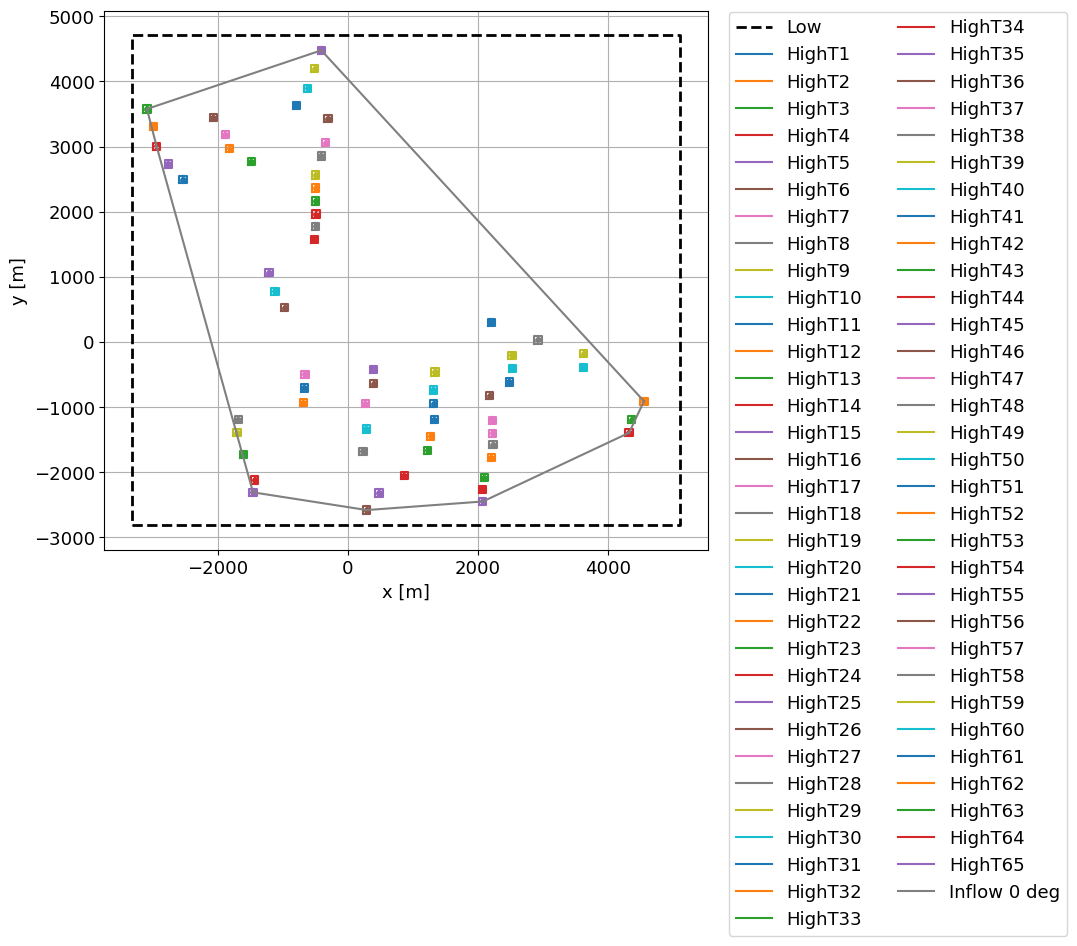

In [74]:
ffcase.plot()

In [75]:
# ----------- Update wake model constants
C_HWkDfl_OY   = 0
C_HWkDfl_xY   = 0
k_VortexDecay = 0
k_vCurl       = 2.8
for cond in range(ffcase.nConditions):
    for case in range(ffcase.nCases):
        for seed in range(ffcase.nSeeds):
            ff_file = os.path.join(ffcase.path, ffcase.condDirList[cond], ffcase.caseDirList[case], f'Seed_{seed}', 'FFarm_mod.fstf')
            modifyProperty(ff_file, 'C_HWkDfl_OY'  , C_HWkDfl_OY  )
            modifyProperty(ff_file, 'C_HWkDfl_xY'  , C_HWkDfl_xY  )
            modifyProperty(ff_file, 'k_VortexDecay', k_VortexDecay)
            modifyProperty(ff_file, 'k_vCurl'      , k_vCurl      )

In [76]:
# ----------- Wake planes to be saved for each turbine (only 9 planes at most can be saved. This case has two turbines)
# The offset is useful if we start sampling at 0 D, so that we actually have an usable plane that is not _at_ the hub plane. Here we are not interested
# in the 0 D plane, so we can set our offset to 0. Leaving it for generality.
# Note: The extent of the box is 6D downstream the last turbine. So we can't sample there, it goes outside the domain. Changing it slightly
wakeplanes_in_D = [2]
offset = 0
# Wake points (not planes). Can have up to 9 per turbine
wakepoints_in_D = [1,2,3,4,5,5.9]


# Add wake plane saving (the hub-height and vertical thought the centerline planes are already properly configured though `FF_setup()`
for cond in range(ffcase.nConditions):
    for case in range(ffcase.nCases):
        for seed in range(ffcase.nSeeds):
            ff_file = os.path.join(ffcase.path, ffcase.condDirList[cond], ffcase.caseDirList[case], f'Seed_{seed}', 'FFarm_mod.fstf')
            # Parameters for the wake locations
            Tx  = ffcase.allCases.isel(case=case).Tx.values
            Tz  = ffcase.allCases.isel(case=case).Tz.values
            Thh = Tz + ffcase.allCases.isel(case=case).zhub.values
            # Wake plane (yz plane)
            outdistYZ = np.array([[w*ffcase.D for w in wakeplanes_in_D]+tx+offset for tx in Tx]).flatten()
            outdiststrYZ = ', '.join(f'{num:.4f}' for num in outdistYZ)
            modifyProperty(ff_file, 'NOutDisWindYZ', len(outdistYZ))
            modifyProperty(ff_file, 'OutDisWindX', outdiststrYZ)
            # Wake (repeated for every turbine within FAST.Farm)
            outdist = np.array([w*ffcase.D+offset for w in wakepoints_in_D]).flatten()
            outdiststr = ', '.join(f'{num:.4f}' for num in outdist)
            modifyProperty(ff_file, 'NOutDist', len(outdist))
            modifyProperty(ff_file, 'OutDist', outdiststr)
            # Horizontal slice
            outdistXY = [np.min(Thh), Thh[0], np.mean(Thh), np.max(Thh)]
            outdiststrXY = ', '.join(f'{num:.4f}' for num in outdistXY)
            modifyProperty(ff_file, 'NOutDisWindXY', len(outdistXY))
            modifyProperty(ff_file, 'OutDisWindZ', outdiststrXY)
            # Let's change the frequency planes are saved (default is dt_low)
            #modifyProperty(ff_file, 'WrDisDT', 1)


In [77]:
ffcase.FF_slurm_prepare(slurm_FF_single)

In [78]:
#ffcase.FF_slurm_submit(A='total', t='4-00')

### 5.2.1. Save object
This object will be opened for FAST.Farm post-processing and contains all the information needed

In [79]:
obj = os.path.join(ffcase.path, 'ff_case.obj')

# Save case instance
dill.dump(ffcase, file = open(obj, 'wb'))

# # Load case instance
# ffcase_reload = dill.load(open(obj, 'rb'))